In [1]:
"""
Artykuł naukowy na temat wykorzystania VGG-16 w detekcji fałszywych twarzy:
https://www.ijraset.com/research-paper/fake-face-detection-using-cnn
Ręczna implementacja VGG-16 z wykorzystaniem Kerasa:
https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c
Dobra praktyka ładowania zdjęć (Keras):
https://www.tensorflow.org/tutorials/load_data/images
Problem jednakowego outputu dla różnych wejść !!!:
https://stackoverflow.com/questions/41881220/keras-predict-always-output-same-value-in-multi-classification
"""

'\nArtykuł naukowy na temat wykorzystania VGG-16 w detekcji fałszywych twarzy:\nhttps://www.ijraset.com/research-paper/fake-face-detection-using-cnn\nRęczna implementacja VGG-16 z wykorzystaniem Kerasa:\nhttps://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c\nDobra praktyka ładowania zdjęć (Keras):\nhttps://www.tensorflow.org/tutorials/load_data/images\n'

In [265]:
# ogólne
import tensorflow as tf
import numpy as np

# ładowanie danych
from keras.preprocessing.image import ImageDataGenerator

# budowanie modelu
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adam

# proces uczenia
from keras.callbacks import ModelCheckpoint, EarlyStopping

# wizualizacja
import matplotlib.pyplot as plt
from keras.utils import load_img
import pickle

# klasyfikacja
from keras.models import load_model

# https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio
tf.config.run_functions_eagerly(True)  
# tf.data.experimental.enable_debug_mode()

In [266]:
# Przygotowanie danych
# https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

train_data = datagen.flow_from_directory(directory="train",
                                         target_size=(224,224),
                                         shuffle=True,
                                         subset='training') # set as training data

valid_data = datagen.flow_from_directory(directory="train",
                                         target_size=(224,224),
                                         shuffle=True,
                                         subset='validation') # set as validation data

test_data = ImageDataGenerator(rescale=1./255)\
    .flow_from_directory(directory="test",
                         target_size=(224,224))

Found 1573 images belonging to 2 classes.
Found 392 images belonging to 2 classes.
Found 25 images belonging to 1 classes.


In [267]:
unique_train = np.unique(train_data.classes, return_counts=True)
labels_dict_train = dict(zip(unique_train[0], unique_train[1]))
print(labels_dict_train)

unique_valid = np.unique(valid_data.classes, return_counts=True)
labels_dict_valid = dict(zip(unique_valid[0], unique_valid[1]))
print(labels_dict_valid)

{0: 735, 1: 838}
{0: 183, 1: 209}


In [268]:
def get_class_weight(data):
    n_samples = len(data)
    n_classes = len(np.unique(data))

    class_weight = dict()

    for classes in np.unique(data):
        score = n_samples/(n_classes*np.bincount(data)[classes])
        class_weight[classes] = score
        
    return class_weight

In [269]:
class_weights = get_class_weight(train_data.classes)
class_weights

{0: 1.0700680272108845, 1: 0.9385441527446301}

In [139]:
"""
filter vs kernel - https://stats.stackexchange.com/questions/154798/difference-between-kernel-and-filter-in-cnn
padding - https://www.geeksforgeeks.org/cnn-introduction-to-padding/
strides - https://medium.com/machine-learning-algorithms/what-is-stride-in-convolutional-neural-network-e3b4ae9baedb
"""

'\nfilter vs kernel - https://stats.stackexchange.com/questions/154798/difference-between-kernel-and-filter-in-cnn\npadding - https://www.geeksforgeeks.org/cnn-introduction-to-padding/\nstrides - https://medium.com/machine-learning-algorithms/what-is-stride-in-convolutional-neural-network-e3b4ae9baedb\n'

In [270]:
# VGG16 - pipeline
input_shape = (224,224,3)
kernel_size = (3,3)
activation = "relu" # relu - so that all the negative values are not passed to the next layer.
padding = "same"
pool_size = (2,2)
strides = (2,2)

model = Sequential()

model.add(Conv2D(input_shape=input_shape, filters=2**6, kernel_size=kernel_size, padding=padding, activation=activation))
model.add(Conv2D(filters=2**6, kernel_size=kernel_size, padding=padding, activation=activation))

model.add(MaxPooling2D(pool_size=pool_size, strides=strides))
model.add(Conv2D(filters=2**7, kernel_size=kernel_size, padding=padding, activation=activation))
model.add(Conv2D(filters=2**7, kernel_size=kernel_size, padding=padding, activation=activation))


model.add(MaxPooling2D(pool_size=pool_size, strides=strides))
model.add(Conv2D(filters=2**8, kernel_size=kernel_size, padding=padding, activation=activation))
model.add(Conv2D(filters=2**8, kernel_size=kernel_size, padding=padding, activation=activation))
model.add(Conv2D(filters=2**8, kernel_size=kernel_size, padding=padding, activation=activation))

model.add(MaxPooling2D(pool_size=pool_size, strides=strides))
model.add(Conv2D(filters=2**9, kernel_size=kernel_size, padding=padding, activation=activation))
model.add(Conv2D(filters=2**9, kernel_size=kernel_size, padding=padding, activation=activation))
model.add(Conv2D(filters=2**9, kernel_size=kernel_size, padding=padding, activation=activation))

model.add(MaxPooling2D(pool_size=pool_size, strides=strides))
model.add(Conv2D(filters=2**9, kernel_size=kernel_size, padding=padding, activation=activation))
model.add(Conv2D(filters=2**9, kernel_size=kernel_size, padding=padding, activation=activation))
model.add(Conv2D(filters=2**9, kernel_size=kernel_size, padding=padding, activation=activation))

model.add(MaxPooling2D(pool_size=pool_size, strides=strides))

model.add(Flatten())
model.add(Dense(units=4096, activation="relu"))
model.add(Dense(units=4096, activation="relu"))
model.add(Dense(units=2, activation="softmax"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_40 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_42 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                 

In [271]:
model.compile(optimizer=Adam(lr=0.001),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

c:\Users\User\Anaconda3\envs\tensorflow_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [275]:
# String formatting rules - https://mkaz.blog/code/python-string-format-cookbook/
steps = 5
epoch = 5

filepath="models/weights-improvement-{epoch:05d}-{val_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

early = EarlyStopping(monitor='val_accuracy',
                      min_delta=0,
                      patience=20,
                      verbose=1,
                      mode='auto')

hist = model.fit_generator(steps_per_epoch=steps,
                           generator=train_data,
                           validation_data=valid_data,
                           validation_steps=1,
                           epochs=epoch,
                           callbacks=[checkpoint,early],
                           class_weight=class_weights)

C:\Users\User\AppData\Local\Temp\ipykernel_40552\1364518201.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(steps_per_epoch=steps,


Epoch 1/5
5/5 [==============================] - ETA: 0s - loss: 0.6968 - accuracy: 0.5000 
Epoch 1: val_accuracy improved from -inf to 0.53125, saving model to models\weights-improvement-         1-0.53.hdf5
5/5 [==============================] - 105s 21s/step - loss: 0.6968 - accuracy: 0.5000 - val_loss: 0.6924 - val_accuracy: 0.5312
Epoch 2/5
5/5 [==============================] - ETA: 0s - loss: 0.7012 - accuracy: 0.4887 
Epoch 2: val_accuracy did not improve from 0.53125
5/5 [==============================] - 85s 16s/step - loss: 0.7012 - accuracy: 0.4887 - val_loss: 0.6964 - val_accuracy: 0.4062
Epoch 3/5
5/5 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5063 
Epoch 3: val_accuracy did not improve from 0.53125
5/5 [==============================] - 99s 20s/step - loss: 0.6932 - accuracy: 0.5063 - val_loss: 0.6952 - val_accuracy: 0.4375
Epoch 4/5
5/5 [==============================] - ETA: 0s - loss: 0.6923 - accuracy: 0.5437 
Epoch 4: val_accuracy improv

In [276]:
# zapisanie historii nauki
name = "epochs_{0}_steps_{1}_val_{2}".format(checkpoint.params['epochs'], checkpoint.params['steps'], checkpoint.best)
with open('trainHistoryDict/{}.pickle'.format(name), 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)

# otwarcie historii nauki
with open('trainHistoryDict/{}.pickle'.format(name), "rb") as file_pi:
    history = pickle.load(file_pi)

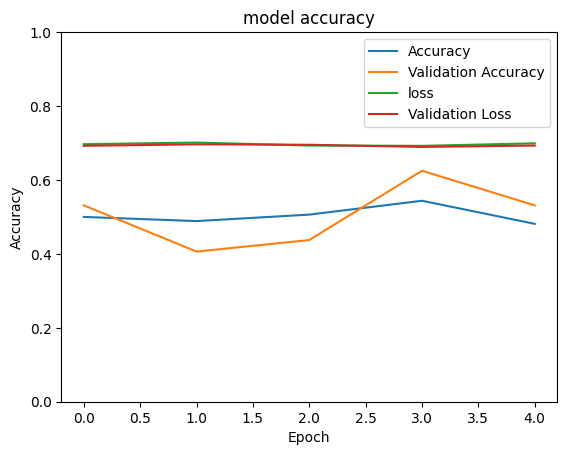

In [277]:
plt.plot(history["accuracy"])
plt.plot(history['val_accuracy'])
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.ylim(0, 1) 
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

[0.43110484 0.56889516]
real face


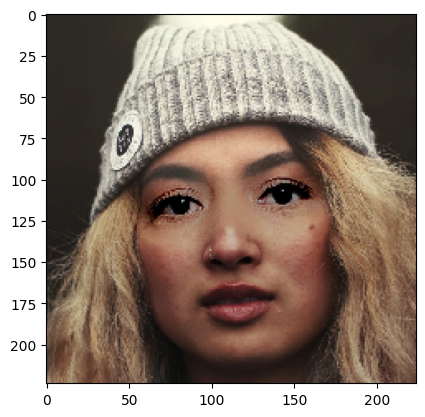

In [292]:
img = load_img("test/TS1/test_image_set1 (13).jpg", target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

saved_model = load_model("models/weights-improvement-         4-0.62.hdf5")
output = saved_model.predict(img, verbose=0)
print(output[0])

if output[0][0] > output[0][1]:
    print("fake face")
else:
    print('real face')